# Deep Learning Project


In [1]:
'''
Train Model on Cloud Jupyter Notebooks 
How to build a Deep Learning Project ..
Uploading KAGGLE.json file 
'''

'\nTrain Model on Cloud Jupyter Notebooks \nHow to build a Deep Learning Project ..\nUploading KAGGLE.json file \n'

In [75]:
!pip install opendatasets --upgrade --quiet

In [76]:
import opendatasets as od

In [77]:
# Uploading the DataSet 

In [78]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [79]:
od.download(dataset_url)
# Uploaded the kaggle.json

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


### Import the Dataset using Pytorch

In [80]:
'''
Use the imagefolder 
'''

'\nUse the imagefolder \n'

In [81]:
data_dir = './flowers-recognition/flowers'

In [82]:
import os

In [83]:
os.listdir(data_dir)

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

### Import the Dataset into Pytorch

In [84]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [85]:
from torchvision.datasets import ImageFolder

In [86]:
dataset = ImageFolder(data_dir)

In [87]:
len(dataset)

4317

In [88]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [89]:
import matplotlib.pyplot as plt 
%matplotlib inline

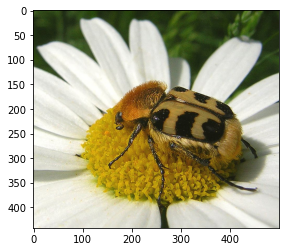

In [90]:
img, label = dataset[120]
plt.imshow(img)

### Want to see as the Pytorch Tensor

In [91]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([ tt.Resize(224), tt.RandomCrop(224),tt.ToTensor()]))

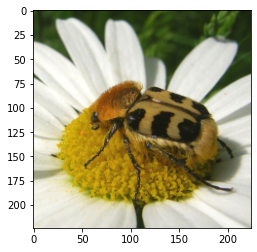

In [92]:
img, label = dataset[120]
plt.imshow(img.permute(1, 2 , 0))

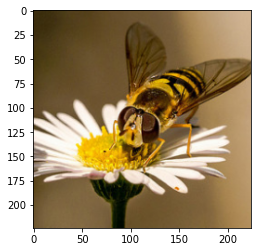

In [131]:
img, label = dataset[200]
plt.imshow(img.permute(1,2,0))

### Splitting the DataSet into Vlidation and Training DataSet

In [93]:
# Random Split 
val_pct = 0.1 
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size , val_size

(3886, 431)

In [94]:
from  torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size , val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [95]:
from torch.utils.data import DataLoader
batch_size = 256  
# Creating a Training and Validation DataLoader 
train_dl = DataLoader(train_ds,
                     batch_size, 
                     shuffle=True,
                     num_workers=4,
                     pin_memory=True)

val_dl = DataLoader(valid_ds,
                   batch_size,
                   num_workers=4,
                   pin_memory=True)


In [96]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images , label in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break;
        

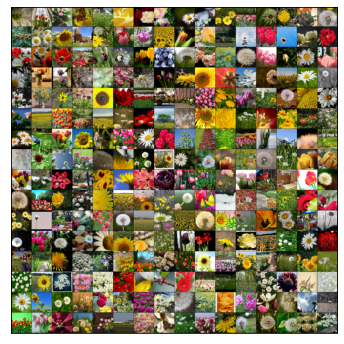

In [97]:
# Creating a Batch of Data 
show_batch(train_dl)

In [98]:
'''
    1. You can look at the Data and tell how dificult it is ? 
    2. Prepare the Dataset for the Training.
'''

'\n    1. You can look at the Data and tell how dificult it is ? \n    2. Prepare the Dataset for the Training.\n'

In [99]:
for cls in os.listdir(data_dir):
    
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

daisy : 764
rose : 784
tulip : 984
dandelion : 1052
sunflower : 733


In [100]:
# Import the DataseT into Pytorch 

In [101]:
## Utility Courses and Classes

In [102]:
import torch

In [103]:
torch.cuda.is_available

<function torch.cuda.is_available() -> bool>

In [104]:
conda info -e

# conda environments:
#
base                  *  /opt/anaconda3


Note: you may need to restart the kernel to use updated packages.


In [105]:
conda activate -n gpu2


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


# GPU Utilities

In [141]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [142]:
torch.cuda.is_available()

False

In [143]:
device = get_default_device()

In [144]:
device

device(type='cpu')

In [145]:
img, label = dataset[0]

In [146]:
img.shape

torch.Size([3, 224, 224])

In [147]:
img.device

device(type='cpu')

In [148]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [125]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilities

In [124]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        "Calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    
    def validation_step(self, batch):
        " Calculate loss & accuracy for a batch of validation data "
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Human Protein Classifications

### Single label - Cross Entropy

In [132]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

### Model

In [133]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# RESET 
# Conv - bn - Relu 
# Convolution , Batch Normalization, Relu Non-Linearity 

In [135]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [137]:
model.conv1[0].weight.device

device(type='cpu')

In [151]:
torch.cuda.empty_cache()

for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([3, 224, 224])
images.device cpu


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 224, 224] instead

In [150]:
history = [evaluate(model, valid_dl)]
history

AttributeError: 'int' object has no attribute 'to'